# CSX46 - Class Session 7 - Closeness Centrality and Pagerank Centrality

In this class session we are going to learn how to compute Closeness Centrality and Pagerank Centrality, using human gene regulatory networks as example graphs.

# Part 1: Closeness Centrality

In this section of the notebook we are going to scatter-plot the harmonic-mean closeness centralities of the vertices in the human gene regulatory network (which we will obtain from Pathway Commons) with the vertices' degree centralities. We will get the geodesic path distances using `igraph`, which will use BFS for this graph.

We are going to use `pandas`, `igraph`, `numpy`, `timeit`, and `matplotlib.pyplot`

In [ ]:
!pip install python-igraph
import igraph, timeit, matplotlib.pyplot
import numpy as np
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.3 MB/s eta 0:00:00


Load in the SIF file for Pathway Commons, using `pandas.read_csv` and specifying the three column names `species1`, `interaction_type`, and `species2`:

In [ ]:
!curl https://csx46.s3-us-west-2.amazonaws.com/PathwayCommons9.All.hgnc.sif.gz --output PathwayCommons9.All.hgnc.sif.gz
!gunzip -f PathwayCommons9.All.hgnc.sif.gz
sif_data = pd.read_csv("PathwayCommons9.All.hgnc.sif",
                       sep="\t", names=["species1","interaction_type","species2"])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5930k  100 5930k    0     0  2547k      0  0:00:02  0:00:02 --:--:-- 2548k


Subset the data frame to include only rows for which the `interaction_type` column contains the string `controls-expression-of`; subset columns to include only columns `species1` and `species2` using the `[` operator and the list `["species1","species2"]`; and eliminate redundant edges in the edge-list using the `drop_duplicates` method. Note: "GRN" is an abbreviation for "gene regulatory network".

In [ ]:
interac_grn = sif_data[sif_data.interaction_type == "controls-expression-of"]
interac_grn_unique = interac_grn[["species1", "species2"]].drop_duplicates()

Create a undirected graph in igraph, from the dataframe edge-list, using `Graph.TupleList` and specifying `directed=False`. (One might object that the actual biological network is more appropriately abstracted as a *directed* graph, but it turns out that if you compute closeness centrality on a directed graph, vertices that have no outgoing edges will have zero centrality regardless of where those vertices are connected in the graph, which makes it not so useful for relatively ranking them). Print out the graph summary using the `summary` instance method.

In [ ]:
grn_igraph = igraph.Graph.TupleList(interac_grn_unique.values.tolist(), directed=False)
grn_igraph.summary()

'IGRAPH UN-- 16378 123232 -- \n+ attr: name (v)'

For one vertex at a time (iterating over the vertex sequence `grn_igraph.vs`), compute that vertex's harmonic mean closeness centrality using Eq. 7.30 from Newman's book. Don't forget to eliminate the "0" distance between a vertex and itself, in the results you get back from calling the `distances` method on the `grn_igraph` object, passing the vertex object as the `source` parameter. Just for information purposes, measure how long the code takes to run, in seconds, using `timeit.default_timer()`.

In [ ]:
# get the number of vertices _N_
N = len(grn_igraph.vs)

# allocate a vector to contain the vertex closeness centralities; initialize to zeroes
# (so if a vertex is a singleton we don't have to update its closeness centrality)
closeness_centralities = np.zeros(N)

# initialize a counter to zero
ctr = 0

# start the timer
start_time = timeit.default_timer()

# for each `my_vertex` in `grn_igraph.vs`
for my_vertex in grn_igraph.vs:

    # compute the geodesic distance to every other vertex, from my_vertex, using
    # the `igraph.Graph.distances` instance method and passing `my_vertex`
    # as the `source` named parameter; put the result in a numpy.array (dtype float)
    my_dists = np.array(grn_igraph.distances(source=my_vertex))

    # filter the numpy array to include only entries that are nonzero and finite,
    # using `> 0 & numpy.isfinite(...)`
    my_dists = my_dists[np.isfinite(my_dists) & (my_dists > 0.0)]

    # if there are any distance values that survived the filtering, take their
    # element-wise reciprocals, then compute the sum, then divide by N-1
    # (following Eq. 7.30 in Newman)
    if len(my_dists) > 0:
        closeness_centralities[ctr] = np.sum(1.0/my_dists)/(N - 1.0)

    # increment ctr
    ctr += 1

# compute and print the elapsed time
ci_elapsed = timeit.default_timer() - start_time
print(f"Elapsed time: {ci_elapsed:.2f}")

Elapsed time: 132.46


Histogram the harmonic-mean closeness centralities.  Do they have a large dynamic range?

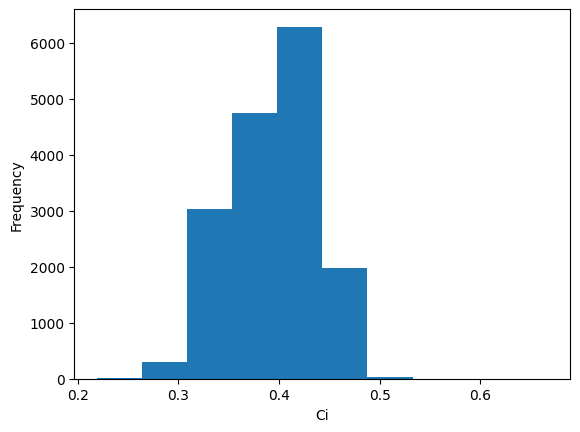

In [ ]:
matplotlib.pyplot.hist(closeness_centralities)
matplotlib.pyplot.xlabel("Ci")
matplotlib.pyplot.ylabel("Frequency")
matplotlib.pyplot.show()

Scatter plot the harmonic-mean closeness centralities vs. the log<sub>10</sub> degree. Is there any kind of relationship?

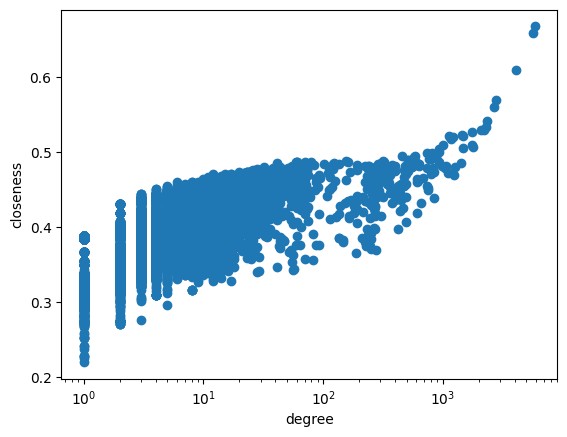

In [ ]:
ax = matplotlib.pyplot.gca()
ax.scatter(grn_igraph.degree(), closeness_centralities)
ax.set_xscale("log")
matplotlib.pyplot.xlabel("degree")
matplotlib.pyplot.ylabel("closeness")
matplotlib.pyplot.show()

Which protein has the highest harmonic-mean closeness centrality in the network, and what is its centrality value? use `numpy.argmax`

In [ ]:
max_cc = np.max(closeness_centralities)
print(f"Maximum closeness centrality value is: {max_cc:.3f}")
print("Maximum closeness centrality protein has gene name: " +
      grn_igraph.vs[np.argmax(closeness_centralities)]["name"])

Maximum closeness centrality value is: 0.667
Maximum closeness centrality protein has gene name: SP1


Print names of the top 10 proteins in the network, by harmonic-mean closeness centrality:, using `numpy.argsort`:

In [ ]:
grn_igraph.vs[np.argsort(closeness_centralities)[::-1][0:9].tolist()]["name"]

['SP1', 'NOG', 'TCF3', 'LEF1', 'MYC', 'MAX', 'MAZ', 'FOXO4', 'SREBF1']

Let's do it using a Pandas `DataFrame`, `list`, and `zip`:

In [ ]:
np.argsort(closeness_centralities)

array([13378,  9054, 13411, ..., 10712,  2865, 11120])

In [1]:
cc_df = pd.DataFrame(list(zip(grn_igraph.vs["name"],
                              closeness_centralities.tolist())),
                     columns=["protein","CC"])
cc_df = cc_df.set_index("protein")
cc_df.sort_values("CC", ascending=False).head(n=10)

NameError: name 'pd' is not defined

# Part 2: Pagerank Centrality

In this section of the notebook we are going to compute the outgoing-edge PageRank centrality of each gene (vertex) in a human gene regulatory network (a directed graph) from a landmark paper on human gene regulation (Neph et al., Cell, volume 150, pages 1274-1286, 2012; [a PDF of the Neph et&nbsp;al paper is available here](https://canvas.oregonstate.edu/courses/1793772/files/folder/Optional%20Reading?preview=80988153).

Using Pandas `read_csv`, read in the ifle `shared/neph_gene_network.txt`, which has two columns of text (first column is the regulator gene, second column is the target gene), into a data frame. The file has no header and is tab-delimited.  Assign the column names of the dataframe to be `regulator` and `target`, respectively.

Assuming you have already run Part 1, all you need to additionally load is the `random` package.

In [ ]:
import random

Download the file `neph_gene_network.txt` from the S3 bucket at URL `https://csx46.s3-us-west-2.amazonaws.com/neph_gene_network.txt`:

In [ ]:
!curl https://csx46.s3-us-west-2.amazonaws.com/neph_gene_network.txt > neph_gene_network.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  522k  100  522k    0     0   340k      0  0:00:01  0:00:01 --:--:--  340k


Inspect the first few rows of `neph_gene_network.txt`, using the shell command `head`

In [ ]:
!head neph_gene_network.txt

AHR	BCL6
AHR	BHLHE41
AHR	BPTF
AHR	CEBPA
AHR	CNOT3
AHR	CREB1
AHR	CREB5
AHR	CTCF
AHR	EGR1
AHR	EGR2


Using `pandas.read_csv`, read the file `neph_gene_network.txt`; name the two columns of the resulting data frame, `regulator` and `target`.

In [ ]:
edge_list_neph = pd.read_csv("neph_gene_network.txt",
                             sep="\t",
                             names=["regulator","target"])

Load the edge-list data into a directed `igraph.Graph` object `neph_graph`, using `igraph.Graph.TupleList`. *Make sure to reverse the columns of the data frame when you input the data frame into `Graph.TupleList` since we want the outgoing pagerank centrality not incoming pagerank centrality.* Print out a summary of the graph, using the `igraph.Graph.summary` method:

In [ ]:
neph_graph = igraph.Graph.TupleList(edge_list_neph[["target","regulator"]].values.tolist(), directed=True)
neph_graph.summary()

'IGRAPH DN-- 538 47945 -- \n+ attr: name (v)'

Compute the pagerank centrality measures of all vertices, using `igraph.Graph.pagerank`.  Use the resulting object to initialize a `numpy.array`, `pageranks`.

In [ ]:
pageranks = np.array(neph_graph.pagerank())

Which vertex has highest pagerank centrality in the gene regulatory network, and what is its pagerank centrality value? (think `numpy.max` and `numpy.argmax`). Get a `VertexSet` sequence using the `igraph.Graph.vs` property, and then index into that sequence using Python indexing:

In [ ]:
max_pr = np.max(pageranks)
print(f"Maximum Pagerank centrality value is: {max_pr:.2f}")
print("Gene name for the vertex with the highest Pagerank centrality is: " + neph_graph.vs[np.argmax(pageranks)]["name"])

Maximum Pagerank centrality value is: 0.01
Gene name for the vertex with the highest Pagerank centrality is: FOS


Calculate the in-degree of all vertices in the graph, and scatter plot `log(degree)` vs. `log(pagerank)`.  (Do you see why we used `in` here?  Note the column swapping we did earlier). Note-- you will have to eliminate one vertex that has zero in-degree.

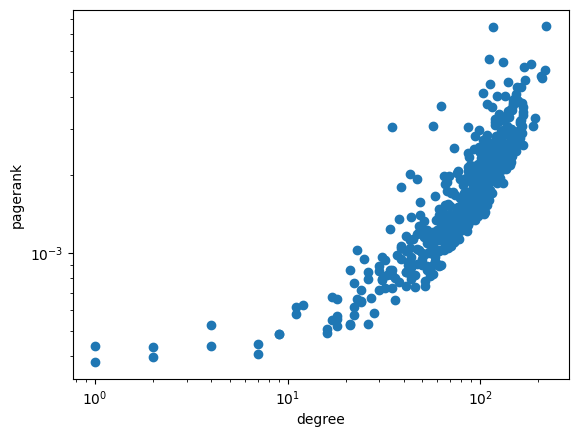

In [ ]:
ax = matplotlib.pyplot.gca()
ax.set_xscale("log")
ax.set_yscale("log")
degrees = np.array(neph_graph.indegree())
inds_keep = np.where(degrees > 0)
ax.scatter(degrees[inds_keep],
           pageranks[inds_keep])
matplotlib.pyplot.xlabel("degree")
matplotlib.pyplot.ylabel("pagerank")
matplotlib.pyplot.show()

See if you can calculate the pagerank centrality yourself, using the matrix inversion method (Eq. 7.19 from Newman). Test your function on a small directed graph.

In [ ]:
def pagerank(g):
    # N is the number of vertices
    N = len(g.vs)

    # alpha is the damping parameter, 0.85
    alpha = 0.85

    # beta = (1-alpha)/N
    beta = (1.0 - alpha)/N

    # compute the out-degree of each vertex, using igraph.Graph.degree with mode=igraph.OUT
    degree_values = g.degree(mode="out")

    # Construct a floating-point adjacency matrix M=A*D^(-1) in the Newman orientation,
    # (i.e., don't forget to take the transpose of the igraph adjacency matrix)
    # where A is the adjacency matrix and D is the diagonal matrix of vertex out-degrees.
    # We'll do this in two steps. First, define M as the Newman-orientation adjacency
    # matrix,
    M = np.matrix(g.get_adjacency().data).transpose().astype(float)

    # and then we will do the "multiply by D^(-1)" step column by column:
    for j in range(0, N):

        # get the out degree of the vertex as a float
        degree_value = float(degree_values[j])

        # if degree is nonzero, normalize the column of M
        # otherwise, set the column to zero
        if degree_value > 0:
            M[:,j] /= degree_value
        else:
            M[:,j] = 0

    # Now implement Newman Eq. 7.19, by computing the difference of I (the
    # identity matrix) and alpha*M, and then inverting it, and then finally
    # multiplying by the beta vector and taking the vector transpose.
    pr = np.linalg.inv(np.diag([1.]*N) - alpha * M) * np.matrix([beta]*N).transpose()

    # Normalize the pagegrank centrality vector by dividing by the sum, so the
    # vector has unit L1 norm.
    pr = pr/np.sum(pr)

    # return the transpose vector, using the numpy.matrix.transpose method
    return(pr.transpose())

Test out your function on a small Barabasi-Albert graph with `n=5` and `m=2`. Compare the Pagerank centralities computed using `igraph.Graph.pagerank` with your function `pagerank`:

In [ ]:
g = igraph.Graph.Barabasi(n=5, m=2)
print("Pagerank computed using the igraph implementation: ")
print(pagerank(g).tolist()[0])
print("Pagerank computed using our numpy implementation: ")
print(g.pagerank())

Pagerank computed using the igraph implementation: 
[0.21240875912408758, 0.21240875912408758, 0.2770649250864387, 0.14905877833269304, 0.14905877833269304]
Pagerank computed using our numpy implementation: 
[0.2124087591240876, 0.2124087591240876, 0.2770649250864387, 0.14905877833269307, 0.14905877833269304]
